In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import sys
import pandas as pd

from aiutils import copy_logistic_model, load
from actioncard import Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch
from config import GameConfig
from enums import StartingSplit, FeatureType
from env import DefaultEnvironment
from mcts import GameTree 
from mctsrunner import train_mcts
from mctsutils import *
from player import init_players
from rollout import LogisticRegressionEnsembleRollout
from victorycard import Province

In [3]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

## Full Dominion MCTS ##

In [4]:
tree_name = 'r-r-mcts-bm-warm-start-100k-srat-base-default-ucb1'
rollout_name = 'mlog-10k-base-default-bm'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [5]:
default_kingdom = [Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch]

In [6]:
# C = lambda x: max(1e-2, min(0.5, 1 / np.sqrt(x)))
# C = lambda x: max(1 / np.sqrt(x + 2), 0.1)
C = lambda x: 1 / np.sqrt(2)
tree = GameTree(train=True, C=C, selection='ucb1', _skip_level=False)

In [7]:
config = GameConfig(sandbox=False, num_players=2, must_include=default_kingdom)
# players = init_players(['UCT', 'DW'], tree=tree, rollout_type='mlog')
player = init_players(['UCT'], tree=tree, rollout_type='mlog')[0]
players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)
idxs = env.game.state.feature.idxs 

In [8]:
rollout = LogisticRegressionEnsembleRollout(train=False)
agent.rollout = rollout

In [9]:
rollout_name = 'default-mlog-100k'
rollout_path = os.path.join(model_dir, rollout_name)
warm_models = load(rollout_path)['models']

In [10]:
for i, model in warm_models.items():
    if i==0:
        continue
    rollout.models[i] = copy_logistic_model(model)

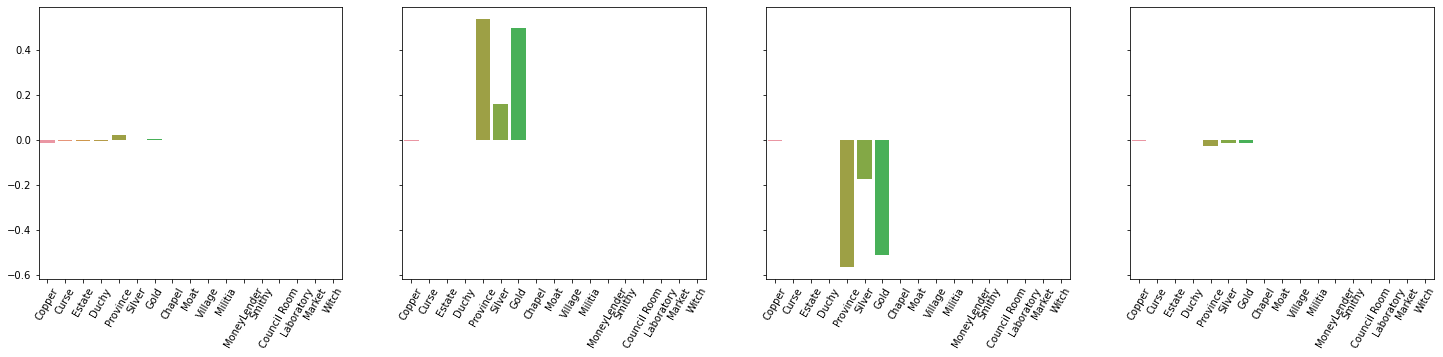

In [12]:
plot_model = agent.rollout.models[8]

agent_weights = plot_model.coef_[0][17:34]
opp_weights = plot_model.coef_[0][34:]
supply_weights = plot_model.coef_[0][:17]
player_weight_diffs = agent_weights + opp_weights
cards = list(str(k()) for k in idxs.keys())

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])

for ax in axes: 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

In [13]:
train_mcts(env=env, tree=tree, epochs=100000, train_epochs_interval=sys.maxsize, save_epochs=10000, path=tree_path, rollout_path=rollout_path, scoring='score_ratio')

100%|██████████| 100000/100000 [55:35<00:00, 29.98it/s]


In [28]:
tree = GameTree.load(tree_path, train=False, _skip_level=False, selection='max')

## Sandbox MCTS Training ##

In [9]:
tree_name = 'r-r-mcts-bm-warm-start-10k-srat-sandbox-ucb1'
rollout_name = 'default-sandbox-mlog-100k'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [5]:
dataset_name = 'train-bm-bm-2k-full'
data_path = os.path.join(project_root, 'datasets', dataset_name)
raw_data = load(data_path)
X, y = raw_data[0], raw_data[1]

In [6]:
# C = lambda x: max(1e-2, min(0.5, 1 / np.sqrt(x)))
# C = lambda x: max(1 / np.sqrt(x + 2), 0.1)
C = lambda x: 1 / np.sqrt(2)
tree = GameTree(train=True, C=C, selection='ucb1', _skip_level=False)

In [7]:
config = GameConfig(sandbox=False, num_players=2, must_include=default_kingdom)
# players = init_players(['UCT', 'DW'], tree=tree, rollout_type='mlog')
player = init_players(['UCT'], tree=tree, rollout_type='mlog')[0]
players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)
idxs = env.game.state.feature.idxs 

In [17]:
rollout = player.rollout
model_name = 'default-sandbox-warm-start'
model_path = os.path.join(model_dir, model_name)
model = load(model_path)
rollout.models[8] = copy_logistic_model(model)

In [8]:
idxs = {'Copper': 0, 'Curse': 1, 'Estate': 2, 'Duchy': 3, 'Province': 4, 'Silver': 5, 'Gold': 6}
cards = list(idxs.keys())

In [35]:
filtered_X_idxs = [(i, x) for i, x in enumerate(X) if x[idxs['Province']] > 5]
filtered_X_idxs = [list(t) for t in zip(*filtered_X_idxs)]
filtered_X = filtered_X_idxs[1]
filtered_y = y[filtered_X_idxs[0]]
assert len(filtered_X) == len(filtered_y)
len(filtered_y)

40927

In [36]:
for i, x in enumerate(filtered_X): 
    rollout.buffers[8].store(x, filtered_y[i])

In [20]:
rollout.train = False

In [21]:
train_mcts(env=env, tree=tree, epochs=10000, train_epochs_interval=500, train_epochs_cap=sys.maxsize, save_epochs=1000, path=tree_path, rollout_path=rollout_path, scoring='score_ratio')

 36%|███▌      | 3624/10000 [04:23<05:57, 17.84it/s]/home/justiny/Documents/Projects/PyDominion/scripts/mctsrunner.py:71: RuntimeWarning: divide by zero encountered in long_scalars
  p0_reward, p1_reward = p0_score / total_score, p1_score / total_score
/home/justiny/Documents/Projects/PyDominion/src/mcts.py:61: RuntimeWarning: invalid value encountered in double_scalars
  self.v += delta
/home/justiny/Documents/Projects/PyDominion/src/aiutils.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return (n - 1) / n * prev_mean + x / n
 47%|████▋     | 4688/10000 [05:32<06:17, 14.08it/s]


KeyboardInterrupt: 

<AxesSubplot:>

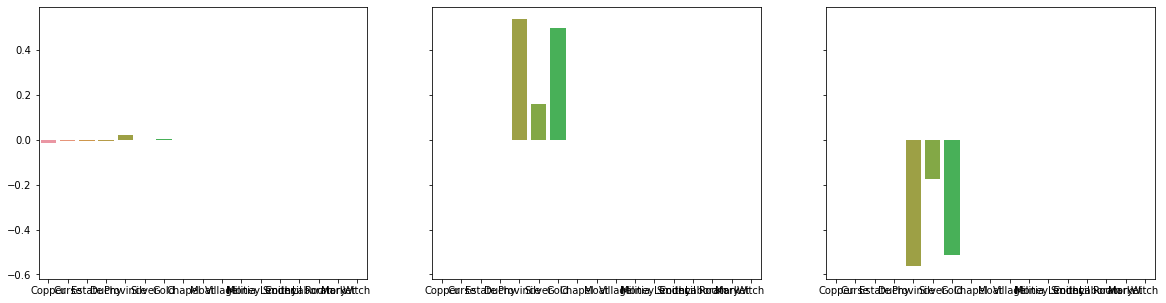

In [19]:
i=8
plot_model = player.rollout.models[i]

agent_weights = plot_model.coef_[0][17:34]
opp_weights = plot_model.coef_[0][34:]
supply_weights = plot_model.coef_[0][:17]
cards = [str(k()) for k in env.game.state.feature.idxs]

f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])

In [106]:
agent_weights_comp = plot_model.coef_[0][7:14]
opp_weights_comp = plot_model.coef_[0][14:]
supply_weights_comp = plot_model.coef_[0][:7]
cards = list(env.game.state.feature.idxs.keys())

<AxesSubplot:>

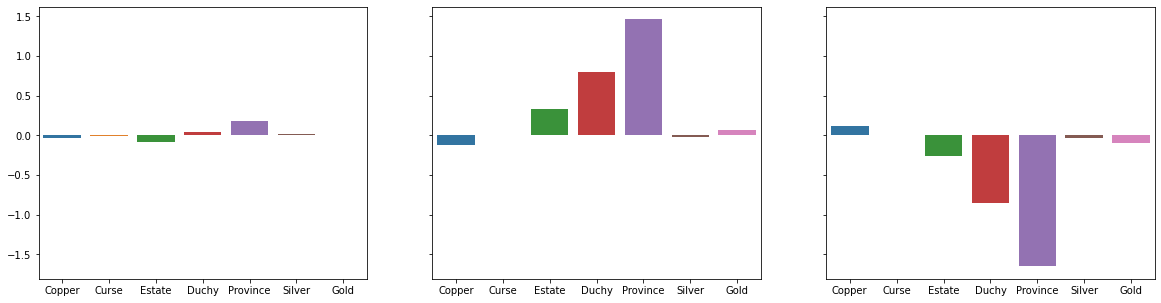

In [107]:
f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights_comp, ax=axes[0])
sns.barplot(x=cards, y=agent_weights_comp, ax=axes[1])
sns.barplot(x=cards, y=opp_weights_comp, ax=axes[2])